In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import os
import csv
import re

**Current directory:** validation

**Consequent:** saved in "data"      

### 1. Missing fields of each report
**input:** split_report(original one)

**output:** missing_field & count & count by type

In [5]:
# ESG framework and extracted data
esg_framework = {
    "B-ENV_GHG_AET": {"required": True, "unit": "tCO2e"},
    "B-ENV_GHG_AE1": {"required": True, "unit": "tCO2e"},
    "B-ENV_GHG_AE2": {"required": True, "unit": "tCO2e"},
    "B-ENV_GHG_AE3": {"required": True, "unit": "tCO2e"},
    "B-ENV_GHG_EIT": {"required": True, "unit": "tCO2e/organisation-specific metrics"},
    "B-ENV_GHG_EI1": {"required": True, "unit": "tCO2e/organisation-specific metrics"},
    "B-ENV_GHG_EI2": {"required": True, "unit": "tCO2e/organisation-specific metrics"},
    "B-ENV_GHG_EI3": {"required": True, "unit": "tCO2e/organisation-specific metrics"},
    "B-ENV_ENC_TEC": {"required": True, "unit": "MWhs or GJ"},
    "B-ENV_ENC_ECI": {"required": True, "unit": "MWhs or GJ/organisation-specific metrics"},
    "B-ENV_WAC_TWC": {"required": True, "unit": "ML or m_"},
    "B-ENV_WAC_WCI": {"required": True, "unit": "ML or m_/organisation-specific metrics"},
    "B-ENV_WAG_TWG": {"required": True, "unit": "t"},
    "B-SOC_GED_CEG_M": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_GED_CEG_F": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_GED_NHG_M": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_GED_NHG_F": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_GED_ETG_M": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_GED_ETG_F": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_CEA_U30": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_CEA_B35": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_CEA_A50": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_NHI_U30": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_NHI_B35": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_NHI_A50": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_TOR_U30": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_TOR_B35": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_TOR_A50": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_DEV_ATH_M": {"required": True, "unit": "Hours/No. of employees"},
    "B-SOC_DEV_ATH_F": {"required": True, "unit": "Hours/No. of employees"},
    "B-SOC_OHS_FAT": {"required": True, "unit": "Number of cases"},
    "B-SOC_OHS_HCI": {"required": True, "unit": "Number of cases"},
    "B-SOC_OHS_REC": {"required": True, "unit": "Number of cases"},
    "B-SOC_OHS_RWI": {"required": True, "unit": "Number of cases"},
    "B-GOV_BOC_BIN": {"required": True, "unit": "Percentage (%)"},
    "B-GOV_BOC_WOB": {"required": True, "unit": "Percentage (%)"},
    "B-GOV_MAD_WMT": {"required": True, "unit": "Percentage (%)"},
    "B-GOV_ETB_ACD": {"required": True},
    "B-GOV_ETB_ACT_N": {"required": True, "unit": "Number"},
    "B-GOV_ETB_ACT_P": {"required": True, "unit": "Percentage (%)"},
    "B-GOV_CER_LRC": {"required": True},
    "B-GOV_ALF_AFD": {"required": True},
    "B-GOV_ASS_ASR": {"required": True}
}

# List of invalid values
invalid_values = {"not available", "null", "none mentioned", "none", "not_available", "unknown", "not specified", "n/a", "0", "not applicable", 
                  "none explicitly mentioned", "not mentioned"}    

# Verify consistency
def check_consistency(extracted_data, framework):
    missing_fields = []
    missing_question_id_count = 0
    empty_response_count = 0
    invalid_value_count = 0
    
    # Get all question_id and related information from extracted data
    extracted_dict = {item["question_id"]: item["response"] for item in extracted_data}
    
    # Check if the required question_id in each frame is in the extracted data
    for key, attributes in framework.items():
        if attributes["required"]:
            if key not in extracted_dict:
                # Increase count if question_id is missing
                missing_fields.append(key)
                missing_question_id_count += 1
            else:
                # Check if the response is empty
                response = extracted_dict[key]
                if not response:  # If response is an empty dictionary
                    missing_fields.append(key)
                    empty_response_count += 1
                else:
                    # Check if the value of the field is valid
                    value = response.get("value", "").strip().lower()
                    if value in invalid_values:
                        missing_fields.append(key)
                        invalid_value_count += 1
    
    return missing_fields, missing_question_id_count, empty_response_count, invalid_value_count

# Specify the JSON file path containing all the reports
json_file_path = "../../data/esg_retrieve/esg_retrieve_result.json"

# Prepare CSV file for output
csv_file_path = '../../data/esg_validation/report_consistency_results.csv'

# Write the results header to CSV
with open(csv_file_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Report", "Section", "Total Missing Fields", "Missing Question ID Count", "Empty Response Count", "Invalid Value Count", "Missing Fields"])

# Read the complete JSON file
with open(json_file_path, "r") as file:
    all_reports_data = json.load(file)

# Consistency check for each report
for report_name, extracted_data in all_reports_data.items():
    missing_fields, missing_question_id_count, empty_response_count, invalid_value_count = check_consistency(extracted_data, esg_framework)
    missing_count = len(missing_fields)  
 
    # Output results to CSV
    with open(csv_file_path, mode="a", newline="") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow([report_name, report_name.split("_")[0], missing_count, missing_question_id_count, empty_response_count, invalid_value_count, "; ".join(missing_fields)])
    
    # Output results
    print(f"Report: {report_name}")
    print(f"Total missing fields count: {missing_count}")
    print(f"Missing question ID count: {missing_question_id_count}")
    print(f"Empty response count: {empty_response_count}")
    print(f"Invalid value count: {invalid_value_count}")
    print(f"Missing fields: {missing_fields}\n")


Report: Great Eastern Holdings Ltd_report
Total missing fields count: 10
Missing question ID count: 0
Empty response count: 0
Invalid value count: 10
Missing fields: ['B-SOC_AGD_CEA_U30', 'B-SOC_AGD_CEA_B35', 'B-SOC_AGD_CEA_A50', 'B-SOC_OHS_FAT', 'B-SOC_OHS_HCI', 'B-SOC_OHS_REC', 'B-SOC_OHS_RWI', 'B-GOV_ETB_ACD', 'B-GOV_ETB_ACT_N', 'B-GOV_ASS_ASR']

Report: Oversea-Chinese Banking Corporation Limited_report
Total missing fields count: 9
Missing question ID count: 0
Empty response count: 0
Invalid value count: 9
Missing fields: ['B-ENV_GHG_EIT', 'B-ENV_GHG_EI1', 'B-ENV_GHG_EI3', 'B-SOC_OHS_FAT', 'B-SOC_OHS_RWI', 'B-GOV_BOC_BIN', 'B-GOV_MAD_WMT', 'B-GOV_ETB_ACD', 'B-GOV_ETB_ACT_N']

Report: UOB-Kay Hian Holdings Limited_report
Total missing fields count: 35
Missing question ID count: 0
Empty response count: 0
Invalid value count: 35
Missing fields: ['B-ENV_GHG_AET', 'B-ENV_GHG_AE1', 'B-ENV_GHG_AE2', 'B-ENV_GHG_AE3', 'B-ENV_GHG_EIT', 'B-ENV_GHG_EI1', 'B-ENV_GHG_EI2', 'B-ENV_GHG_EI3', 'B-E

### 2. Remove repetitive units for percentage("%" in "value")

In [6]:
def count_and_clean_percent_in_report(file_path):
    # Read JSON files
    with open(file_path, 'r', encoding='utf-8') as f:
        extracted_data = json.load(f)

    # of counts used to store each report containing a percent sign
    report_percent_count = {}

    # Traversing each report
    for report, metrics in extracted_data.items():
        count = 0
        # Traverse each indicator in each report
        for metric in metrics:
            response = metric.get('response', {})
            value = response.get('value', "")
            
            if "%" in value:
                count += 1
                # Clear the percent sign
                response["value"] = value.replace("%", "")
        
        # Counts with percent signs in each report are stored in a dictionary
        report_percent_count[report] = count

    # Return modified data and percentile counts for each report
    return extracted_data, report_percent_count

# Call functions for processing
modified_data, percent_counts = count_and_clean_percent_in_report('../../data/esg_retrieve/results_20241108_230051.json')


# Save the modified data as a new JSON file
json_output_path = '../../data/esg_validation/modified_results_1.json'  # 输出文件1
with open(json_output_path, 'w', encoding='utf-8') as f:
    json.dump(modified_data, f, ensure_ascii=False, indent=4)
    
# Output the count of entries with percent signs in each report to a CSV file
csv_output_path = '../../data/esg_validation/percent_count_in_reports.csv'

with open(csv_output_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    
    # Table header
    writer.writerow(["Report Name", "Count"])

    # Count for each report
    for report_name, count in percent_counts.items():
        writer.writerow([report_name, count])    
    
# Output the count of "value" with a percent sign for each report
print(json.dumps(percent_counts, indent=4))

{
    "Great Eastern Holdings Ltd_report": 0,
    "Oversea-Chinese Banking Corporation Limited_report": 0,
    "UOB-Kay Hian Holdings Limited_report": 0,
    "ValueMax Group Limited_report": 0,
    "Sing Investments & Finance Limited_report": 0,
    "Hong Leong Finance Limited_report": 0,
    "Singapore Exchange Limited_report": 0,
    "IFS Capital Limited_report": 1,
    "Hotung Investment Holdings Limited_report": 0,
    "AF Global Limited_report": 0,
    "Pine Capital Group Limited_report": 0,
    "Transcorp Holdings Limited_report": 0,
    "Uni-Asia Group Limited_report": 12,
    "Courage Investment Group Limited_report": 0,
    "Pacific Century Regional Developments Limited_report": 0,
    "Forise International Limited_report": 19,
    "DBS Group Holdings Limited_report": 0,
    "GK Goh Holdings Limited_report": 0,
    "British and Malayan Holdings Limited_report": 1,
    "Singapura Finance Ltd_report": 0,
    "Maxi-Cash Financial Services Corporation Ltd_report": 0,
    "Singapor

### 3. After removing the "%" from "value", it recognizes "value" which should be output as a number but is actually output as text.
**Note:** This part directly identifies the number of missing_fields ("value") in the first 43 metrics and replaces them all with "N/A".

    "B-ENV_GHG_AET",
    "B-ENV_GHG_AE1",
    "B-ENV_GHG_AE2",
    "B-ENV_GHG_AE3",
    "B-ENV_GHG_EIT",
    "B-ENV_GHG_EI1",
    "B-ENV_GHG_EI2",
    "B-ENV_GHG_EI3",  
    "B-ENV_ENC_TEC",
    "B-ENV_ENC_ECI",
    "B-ENV_WAC_TWC",
    "B-ENV_WAC_WCI",
    "B-ENV_WAG_TWG",
    "B-SOC_GED_CEG_M",
    "B-SOC_GED_CEG_F",
    "B-SOC_GED_NHG_M",
    "B-SOC_GED_NHG_F",
    "B-SOC_GED_ETG_M",
    "B-SOC_GED_ETG_F",
    "B-SOC_AGD_CEA_U30",
    "B-SOC_AGD_CEA_B35",
    "B-SOC_AGD_CEA_A50",
    "B-SOC_AGD_NHI_U30",
    "B-SOC_AGD_NHI_B35",
    "B-SOC_AGD_NHI_A50",
    "B-SOC_AGD_TOR_U30",
    "B-SOC_AGD_TOR_B35",
    "B-SOC_AGD_TOR_A50",
    "B-SOC_DEV_ATH_M",
    "B-SOC_DEV_ATH_F",
    "B-SOC_OHS_FAT",
    "B-SOC_OHS_HCI",
    "B-SOC_OHS_REC",
    "B-SOC_OHS_RWI",
    "B-GOV_BOC_BIN",
    "B-GOV_BOC_WOB",
    "B-GOV_MAD_WMT",
    "B-GOV_ETB_ACD",
    "B-GOV_ETB_ACT_N",
    "B-GOV_ETB_ACT_P",
    "B-SOC-EMP-TNM",
    "B-SOC-EMP-TTN"

In [7]:
def count_and_replace_invalid_value(file_path):
    # A list of question_ids that need to be checked for numbers
    numeric_question_ids = {
        "B-ENV_GHG_AET", "B-ENV_GHG_AE1", "B-ENV_GHG_AE2", "B-ENV_GHG_AE3",
        "B-ENV_GHG_EIT", "B-SOC_AGD_TOR_B35", "B-SOC_AGD_TOR_A50",
        "B-SOC_DEV_ATH_M", "B-SOC_DEV_ATH_F", "B-SOC_OHS_FAT", "B-SOC_OHS_HCI",
        "B-SOC_OHS_REC", "B-SOC_OHS_RWI", "B-GOV_BOC_BIN", "B-GOV_BOC_WOB",
        "B-GOV_MAD_WMT", "B-GOV_ETB_ACD", "B-GOV_ETB_ACT_N", "B-GOV_ETB_ACT_P",
        "B-ENV_GHG_EI1", "B-ENV_GHG_EI2", "B-ENV_GHG_EI3", "B-ENV_ENC_TEC",
        "B-ENV_ENC_ECI", "B-ENV_WAC_TWC", "B-ENV_WAC_WCI", "B-ENV_WAG_TWG",
        "B-SOC_GED_CEG_M", "B-SOC_GED_CEG_F", "B-SOC_GED_NHG_M", "B-SOC_GED_NHG_F",
        "B-SOC_GED_ETG_M", "B-SOC_GED_ETG_F", "B-SOC_AGD_CEA_U30", "B-SOC_AGD_CEA_B35",
        "B-SOC_AGD_CEA_A50", "B-SOC_AGD_NHI_U30", "B-SOC_AGD_NHI_B35", "B-SOC_AGD_NHI_A50",
        "B-SOC_AGD_TOR_U30", "B-SOC-EMP-TNM", "B-SOC-EMP-TTN"
    }

    # Read JSON files
    with open(file_path, 'r', encoding='utf-8') as f:
        extracted_data = json.load(f)

    # Used to store the count of invalid values in each report
    invalid_value_counts = {}

    # Traversing each report
    for report, metrics in extracted_data.items():
        invalid_count = 0
        
        # Traverse each indicator in each report
        for metric in metrics:
            question_id = metric.get('question_id', "")
            response = metric.get('response', {})
            value = response.get('value', "")
            
            # Only check if question_id is in the list to be checked
            if question_id in numeric_question_ids:
                # Check if value is a number
                try:
                    float_value = float(value)  # Trying to convert to floating numbers        
                except ValueError:  # If the conversion fails
                    # If value is not a valid number, change to “N/A”.
                    response["value"] = "N/A"
                    invalid_count += 1
        
        # Store the number of invalid values in each report in a dictionary
        invalid_value_counts[report] = invalid_count

    # Return modified data and count of invalid values per report
    return extracted_data, invalid_value_counts

# Input file path
file_path = '../../data/esg_validation/modified_results_1.json'

# Call functions for processing
modified_data, invalid_counts = count_and_replace_invalid_value(file_path)

# Ensure output file path
output_file_path = '../../data/esg_validation/modified_results_2.json'

# Save modified data
with open(output_file_path, 'w', encoding='utf-8') as f:
    json.dump(modified_data, f, ensure_ascii=False, indent=4)

# Export the count of invalid values in each report to a CSV file
csv_file_path = '../../data/esg_validation/invalid_value_counts.csv'

with open(csv_file_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    
    # Table header
    writer.writerow(["Report Name", "Invalid Value Count"])

    # Count of invalid values for each report
    for report_name, count in invalid_counts.items():
        writer.writerow([report_name, count])

# Output the count of invalid values in each report
print(json.dumps(invalid_counts, indent=4))

{
    "Great Eastern Holdings Ltd_report": 5,
    "Oversea-Chinese Banking Corporation Limited_report": 6,
    "UOB-Kay Hian Holdings Limited_report": 33,
    "ValueMax Group Limited_report": 27,
    "Sing Investments & Finance Limited_report": 3,
    "Hong Leong Finance Limited_report": 5,
    "Singapore Exchange Limited_report": 21,
    "IFS Capital Limited_report": 30,
    "Hotung Investment Holdings Limited_report": 25,
    "AF Global Limited_report": 31,
    "Pine Capital Group Limited_report": 36,
    "Transcorp Holdings Limited_report": 35,
    "Uni-Asia Group Limited_report": 16,
    "Courage Investment Group Limited_report": 10,
    "Pacific Century Regional Developments Limited_report": 32,
    "Forise International Limited_report": 12,
    "DBS Group Holdings Limited_report": 16,
    "GK Goh Holdings Limited_report": 14,
    "British and Malayan Holdings Limited_report": 37,
    "Singapura Finance Ltd_report": 10,
    "Maxi-Cash Financial Services Corporation Ltd_report": 31

### 4. Unify units，counts for each report
    "t": ["tons", "metric tons", "tonnes"], 
    "tCO2e": ["tonnes of CO2 equivalent", "tonnes of CO2e", "tonnes of carbon dioxide equivalent", "tonnes CO2e"],
    "m³": ["m³", "cubic meters"],
    "Percentage (%)": ["%", "percent", "percentage"],

In [8]:
# Read JSON files
with open("../../data/esg_validation/modified_results_2.json", "r") as file:
    data = json.load(file)

# Define standard unit mappings
unit_mappings = {
    "t": ["tons", "metric tons", "tonnes"],
    "tCO2e": ["tonnes of CO2 equivalent", "tonnes of CO2e", "tonnes of carbon dioxide equivalent", "tonnes CO2e"],
    "m³": ["m³", "cubic meters"],
    "Percentage (%)": ["%", "percent", "percentage"]
}

# CSV file path
csv_file_path = "../../data/esg_validation/unit_replacement_summary.csv"

# Open CSV file and write data
with open(csv_file_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
   
    # Write to table header
    writer.writerow(["Report Name", "Total Unit Replacements"])

    # Processing data
    for report_name, metrics in data.items():
        count_replacements = 0
        for metric in metrics:
            response = metric.get("response", {})
            unit = response.get("unit")
            if unit:
                for standard_unit, synonyms in unit_mappings.items():
                    if unit in synonyms:
                        response["unit"] = standard_unit  # Replace with standard units
                        count_replacements += 1           # Counting
                        break                             # Jump out of the loop when finding a match

        # Output replacement counts for each report
        print(f"Report '{report_name}' - Total unit replacements: {count_replacements}")
        
        # Write report names and replacement counts to CSV files
        writer.writerow([report_name, count_replacements])

# Save modified data
with open("../../data/esg_validation/modified_results_3.json", "w") as file:
    json.dump(data, file, indent=4)

Report 'Great Eastern Holdings Ltd_report' - Total unit replacements: 25
Report 'Oversea-Chinese Banking Corporation Limited_report' - Total unit replacements: 19
Report 'UOB-Kay Hian Holdings Limited_report' - Total unit replacements: 21
Report 'ValueMax Group Limited_report' - Total unit replacements: 23
Report 'Sing Investments & Finance Limited_report' - Total unit replacements: 21
Report 'Hong Leong Finance Limited_report' - Total unit replacements: 21
Report 'Singapore Exchange Limited_report' - Total unit replacements: 19
Report 'IFS Capital Limited_report' - Total unit replacements: 5
Report 'Hotung Investment Holdings Limited_report' - Total unit replacements: 21
Report 'AF Global Limited_report' - Total unit replacements: 21
Report 'Pine Capital Group Limited_report' - Total unit replacements: 20
Report 'Transcorp Holdings Limited_report' - Total unit replacements: 5
Report 'Uni-Asia Group Limited_report' - Total unit replacements: 21
Report 'Courage Investment Group Limited_

### 5. Missing_fields("value" & empty response) of three text metrics
"B-GOV_CER_LRC", "B-GOV_ALF_AFD", "B-GOV_ASS_ASR"

In [64]:
# Read JSON files
with open("../../data/esg_validation/modified_results_3.json", "r") as file:
    data = json.load(file)

# List of invalid values
invalid_values_gov = {"none", "null", "None explicitly mentioned", "Not mentioned", "None", "Not Available", "None mentioned"}

# Target question_id list
target_question_ids = {"B-GOV_CER_LRC", "B-GOV_ALF_AFD", "B-GOV_ASS_ASR"}

# CSV file path
csv_file_path = "../../data/esg_validation/text_metrics_invalid_value_counts.csv"

# Open CSV file
with open(csv_file_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Report Name", "Invalid Value Count"])
    for report_name, metrics in data.items():
        invalid_count = 0
        
        for metric in metrics:
            question_id = metric.get("question_id")
            
            if question_id in target_question_ids:
                response = metric.get("response", {})
                value = response.get("value")
                
                if not response or value in invalid_values_gov:
                    metric["response"]["value"] = "N/A"  # Modified to standard invalid value expression
                    invalid_count += 1                   # Counting invalid values


        print(f"Report '{report_name}' - Invalid value count: {invalid_count}")
        writer.writerow([report_name, invalid_count])

# Save modified data
with open("../../data/esg_validation/modified_results_4.json", "w") as file:
    json.dump(data, file, indent=4)

Report 'Great Eastern Holdings Ltd_report' - Invalid value count: 1
Report 'Oversea-Chinese Banking Corporation Limited_report' - Invalid value count: 0
Report 'UOB-Kay Hian Holdings Limited_report' - Invalid value count: 1
Report 'ValueMax Group Limited_report' - Invalid value count: 1
Report 'Sing Investments & Finance Limited_report' - Invalid value count: 0
Report 'Hong Leong Finance Limited_report' - Invalid value count: 0
Report 'Singapore Exchange Limited_report' - Invalid value count: 0
Report 'IFS Capital Limited_report' - Invalid value count: 0
Report 'Hotung Investment Holdings Limited_report' - Invalid value count: 0
Report 'AF Global Limited_report' - Invalid value count: 1
Report 'Pine Capital Group Limited_report' - Invalid value count: 0
Report 'Transcorp Holdings Limited_report' - Invalid value count: 0
Report 'Uni-Asia Group Limited_report' - Invalid value count: 0
Report 'Courage Investment Group Limited_report' - Invalid value count: 0
Report 'Pacific Century Region

### 6. Groups of metrics whose sum is 1

    "B-SOC_GED_CEG_M": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_GED_CEG_F": {"required": True, "unit": "Percentage (%)"},

    "B-SOC_GED_NHG_M": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_GED_NHG_F": {"required": True, "unit": "Percentage (%)"},

    "B-SOC_AGD_CEA_U30": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_CEA_B35": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_CEA_A50": {"required": True, "unit": "Percentage (%)"},

    "B-SOC_AGD_NHI_U30": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_NHI_B35": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_NHI_A50": {"required": True, "unit": "Percentage (%)"},
    
    "B-SOC_AGD_TOR_U30": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_TOR_B35": {"required": True, "unit": "Percentage (%)"},
    "B-SOC_AGD_TOR_A50": {"required": True, "unit": "Percentage (%)"},

In [73]:
# Read JSON files
with open("../../data/esg_validation/modified_results_4.json", "r") as file:
    data = json.load(file)

# Define each group question_id and its information
question_groups = {
    "group_1": ["B-SOC_GED_CEG_M", "B-SOC_GED_CEG_F"],
    "group_2": ["B-SOC_GED_NHG_M", "B-SOC_GED_NHG_F"],
    "group_3": ["B-SOC_AGD_CEA_U30", "B-SOC_AGD_CEA_B35", "B-SOC_AGD_CEA_A50"],
    "group_4": ["B-SOC_AGD_NHI_U30", "B-SOC_AGD_NHI_B35", "B-SOC_AGD_NHI_A50"],
    "group_5": ["B-SOC_AGD_TOR_U30", "B-SOC_AGD_TOR_B35", "B-SOC_AGD_TOR_A50"]
}

# CSV file path
csv_file_path = "../../data/esg_validation/report_summary.csv"

# Open CSV file and write data
with open(csv_file_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    
    # Table header
    writer.writerow(["Report Name", "Group", "Valid Count", "Total Sum", "Sum in Range (97, 103)"])
    
    # Processing data
    for report_name, metrics in data.items():
        print(f"\nReport: {report_name}")
        
        for group_name, question_ids in question_groups.items():
            valid_count = 0                 # Valid value count
            total_value_sum = 0.0           # Sum of valid values
        
        # Iterate over each question_id and compute the rms value and the sum
            for metric in metrics:
                question_id = metric.get("question_id")
            
            # Check if question_id is in the current group
                if question_id in question_ids:
                    response = metric.get("response", {})
                    value = response.get("value")
                
                # Check if value is a valid value
                    if value not in {"N/A", None} and response:  
                        try:
                            total_value_sum += float(value)
                            valid_count += 1
                        except ValueError:
                            pass            # Skip non-numeric values that cannot be converted
            
            # Output results for each question_id group
            print(f"  {group_name} - Valid Count: {valid_count}, Total Sum: {total_value_sum}")
        
            # Determine if the sum is within the range (97, 103)
            in_range = 97 < total_value_sum < 103
            print(f"    Sum in range (97, 103): {in_range}")
            
            # Write to CSV file
            writer.writerow([report_name, group_name, valid_count, total_value_sum, in_range])


Report: Great Eastern Holdings Ltd_report
  group_1 - Valid Count: 2, Total Sum: 100.0
    Sum in range (97, 103): True
  group_2 - Valid Count: 2, Total Sum: 100.0
    Sum in range (97, 103): True
  group_3 - Valid Count: 0, Total Sum: 0.0
    Sum in range (97, 103): False
  group_4 - Valid Count: 3, Total Sum: 99.91000000000001
    Sum in range (97, 103): True
  group_5 - Valid Count: 3, Total Sum: 99.96000000000001
    Sum in range (97, 103): True

Report: Oversea-Chinese Banking Corporation Limited_report
  group_1 - Valid Count: 2, Total Sum: 100.0
    Sum in range (97, 103): True
  group_2 - Valid Count: 2, Total Sum: 100.0
    Sum in range (97, 103): True
  group_3 - Valid Count: 3, Total Sum: 100.0
    Sum in range (97, 103): True
  group_4 - Valid Count: 3, Total Sum: 100.0
    Sum in range (97, 103): True
  group_5 - Valid Count: 3, Total Sum: 100.0
    Sum in range (97, 103): True

Report: UOB-Kay Hian Holdings Limited_report
  group_1 - Valid Count: 2, Total Sum: 100.0
   

### 7. Unify "value" of "B-GOV_ASS_ASR"
**step 1:** Find all reports that have "internal" or/and "external" or "N/A" fields in "value" under the question_id "B-GOV_ASS_ASR", and keep only those fields (upper case and lower case are acceptable) that correspond to these fields in the "value". (uppercase and lowercase are fine)

**step 2:** Perform the following operations on the modified json file generated after completing step 1, all the reports that do not have "internal" or "external" or "N/A" fields in the "value" under the question_id "B-GOV_ASS_ASR" or "N/A" fields under the question_id "ASSOV_ASSR" are output to a csv file.

In [ ]:
with open('../../data/esg_validation/modified_results_4.json', 'r') as file:
    data = json.load(file)

# Specify keywords to match (ignore case)
keywords = {"internal", "external", "N/A"}

# Step 1: Filter and retain the specified keywords in "value"
modified_data = {}  
for report, responses in data.items():
    modified_responses = []
    for response in responses:
        if response.get("question_id") == "B-GOV_ASS_ASR":
            value = response["response"].get("value", "")
            # Find matching keywords
            found_keywords = {kw for kw in keywords if re.search(rf'\b{kw}\b', value, re.IGNORECASE)}
            # If keywords are found, keep them as new value
            if found_keywords:
                response["response"]["value"] = ", ".join(found_keywords)
            modified_responses.append(response)
        else:
            modified_responses.append(response)
    modified_data[report] = modified_responses

# Save the modified JSON file
with open('../../data/esg_validation/modified_results_5.json', 'w') as file:
    json.dump(modified_data, file, indent=2)

# Step 2: Find entries in 'value' that don't contain any keywords and export to CSV
rows_to_export = []
for report, responses in modified_data.items():
    for response in responses:
        if response.get("question_id") == "B-GOV_ASS_ASR":
            value = response["response"].get("value", "")
            # If 'value' does not contain any keywords
            if not any(re.search(rf'\b{kw}\b', value, re.IGNORECASE) for kw in keywords):
                rows_to_export.append({"report": report, "question_id": response["question_id"], "value": value})

# Convert to DataFrame and export to CSV file
df = pd.DataFrame(rows_to_export)
df.to_csv('../../data/esg_validation/B-GOV_ASS_ASR_special_keywords.csv', index=False)

### 8. Compute confidence score

In [ ]:
df1_consistency = pd.read_csv("../../data/esg_validation/report_consistency_results.csv")       
df2_percent_sign = pd.read_csv("../../data/esg_validation/percent_count_in_reports.csv")
df3_number_invalid = pd.read_csv("../../data/esg_validation/invalid_value_counts.csv")
df4_unit_replacement = pd.read_csv("../../data/esg_validation/unit_replacement_summary.csv")
df5_text_metrics = pd.read_csv("../../data/esg_validation/text_metrics_invalid_value_counts.csv")
df6_percent_sum = pd.read_csv("../../data/esg_validation/report_summary.csv")

df1_consistency.head(2)
df1_consistency = df1_consistency[["Section", "Total Missing Fields", "Missing Question ID Count", "Empty Response Count", 
                                   "Invalid Value Count", "Missing Fields"]]
df1_consistency.rename(columns={'Section': 'report', 
                                'Total Missing Fields': 'total_missing_fields_count',
                                "Missing Question ID Count": "missing_question_id_count",
                                "Empty Response Count": "empty_response_count",
                                "Invalid Value Count": "invalid_value_count",
                                "Missing Fields": "missing_fields"
                                }, 
                       inplace=True)
df1_consistency.head(2)

df2_percent_sign.head(2)
df2_percent_sign.rename(columns={'Report Name': 'report', 
                                'Count': 'repeat_percent_sign_count'
                                }, 
                       inplace=True)
df2_percent_sign.head(2)

df3_number_invalid.head(2)
df3_number_invalid.rename(columns={'Report Name': 'report', 
                                   'Invalid Value Count': 'invalid_value_number_count'
                                  }, 
                       inplace=True)
df3_number_invalid.head(2)

df4_unit_replacement.head(2)
df4_unit_replacement.rename(columns={'Report Name': 'report', 
                                     'Total Unit Replacements': 'unit_replacement_count'
                                    }, 
                            inplace=True)
df4_unit_replacement.head(2)

df5_text_metrics.head(2)
df5_text_metrics.rename(columns={'Report Name': 'report', 
                                 'Invalid Value Count': 'text_metrics_invalid_value_count'
                                 }, 
                        inplace=True)
df5_text_metrics.head(2)

df6_percent_sum.head(2)
df6_percent_sum.rename(columns={'Report Name': 'report', 
                                'Group': 'group',
                                'Valid Count': 'valid_value_count',
                                'Total Sum': 'percent_sum',
                                'Sum in Range (97, 103)': 'sum_in_range_97_103'
                                 }, 
                        inplace=True)
df6_percent_sum.head(2)

merged_df = (
    df1_consistency.merge(df2_percent_sign, on='report', how='left')
       .merge(df3_number_invalid, on='report', how='left')
       .merge(df4_unit_replacement, on='report', how='left')
       .merge(df5_text_metrics, on='report', how='left')
)

merged_df["demerit_point"] = merged_df["missing_question_id_count"] * 1 + (merged_df["invalid_value_number_count"] + merged_df["text_metrics_invalid_value_count"] - merged_df["invalid_value_count"]) * 0.3 + merged_df["unit_replacement_count"] * 0.3 + merged_df["repeat_percent_sign_count"] * 0.3

merged_df["score1"] = (45 - merged_df["demerit_point"])/45

merged_df.head()

,report,total_missing_fields_count,missing_question_id_count,empty_response_count,invalid_value_count,missing_fields,repeat_percent_sign_count,invalid_value_number_count,unit_replacement_count,text_metrics_invalid_value_count,demerit_point,score1
0,Great Eastern Holdings Ltd,10,0,0,10,B-SOC_AGD_CEA_U30; B-SOC_AGD_CEA_B35; B-SOC_AG...,NaN,NaN,NaN,NaN,NaN,NaN
1,Oversea-Chinese Banking Corporation Limited,9,0,0,9,B-ENV_GHG_EIT; B-ENV_GHG_EI1; B-ENV_GHG_EI3; B...,NaN,NaN,NaN,NaN,NaN,NaN
2,UOB-Kay Hian Holdings Limited,35,0,0,35,B-ENV_GHG_AET; B-ENV_GHG_AE1; B-ENV_GHG_AE2; B...,NaN,NaN,NaN,NaN,NaN,NaN
3,ValueMax Group Limited,28,0,0,28,B-ENV_GHG_AE1; B-ENV_GHG_AE2; B-ENV_GHG_AE3; B...,NaN,NaN,NaN,NaN,NaN,NaN
4,Sing Investments & Finance Limited,8,0,0,8,B-ENV_GHG_AE3; B-ENV_GHG_EI3; B-ENV_WAG_TWG; B...,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

df6_percent_sum['recognization'] = 0

def check_conditions(row):
    if (row['group'] == 'group_1' or row['group'] == 'group_2') and row['valid_value_count'] == 2:
        valid_count_condition = True
    elif (row['group'] == 'group_3' or row['group'] == 'group_4' or row['group'] == 'group_5') and row['valid_value_count'] == 3:
        valid_count_condition = True
    else:
        valid_count_condition = False
    
    sum_range_condition = row['sum_in_range_97_103'] == False

    return 1 if valid_count_condition and sum_range_condition else 0

df6_percent_sum['recognization'] = df6_percent_sum.apply(check_conditions, axis=1)

report_recognization_sum = df6_percent_sum.groupby('report')['recognization'].sum().reset_index()

report_recognization_sum.columns = ['report', 'recognization_sum']


In [88]:
df = merged_df.merge(report_recognization_sum, on='report', how='left')

df['demerit_point'] = df['demerit_point'] + df['recognization_sum']
df['final_score'] = (45 - df["demerit_point"])/45

df.head()

,report,total_missing_fields_count,missing_question_id_count,empty_response_count,invalid_value_count,missing_fields,repeat_percent_sign_count,invalid_value_number_count,unit_replacement_count,text_metrics_invalid_value_count,demerit_point,score1,recognization_sum,final_score
0,Courage Investment Group Limited_report,15,0,0,15,B-ENV_GHG_AE1; B-ENV_GHG_EI1; B-ENV_WAC_TWC; B...,0,10,24,0,6.7,0.873333,1,0.851111
1,UOB-Kay Hian Holdings Limited_report,34,0,0,34,B-ENV_GHG_AET; B-ENV_GHG_AE1; B-ENV_GHG_AE2; B...,0,33,21,1,6.3,0.860000,0,0.860000
2,Forise International Limited_report,30,0,0,30,B-ENV_GHG_AET; B-ENV_GHG_AE1; B-ENV_GHG_AE2; B...,19,12,20,0,9.3,0.860000,3,0.793333
3,Uni-Asia Group Limited_report,1,0,0,1,B-SOC_OHS_RWI,12,16,21,0,14.4,0.680000,0,0.680000
4,Jasper Investments Limited_report,41,0,0,41,B-ENV_GHG_AET; B-ENV_GHG_AE1; B-ENV_GHG_AE2; B...,0,37,20,0,4.8,0.893333,0,0.893333


(array([ 2.,  0.,  2.,  0.,  0.,  1.,  3.,  4., 10.,  4.,  5.,  0.,  1.,
         1.,  1.]),
 array([0.60930233, 0.63674419, 0.66418605, 0.69162791, 0.71906977,
        0.74651163, 0.77395349, 0.80139535, 0.82883721, 0.85627907,
        0.88372093, 0.91116279, 0.93860465, 0.96604651, 0.99348837,
        1.02093023]),
 <BarContainer object of 15 artists>)

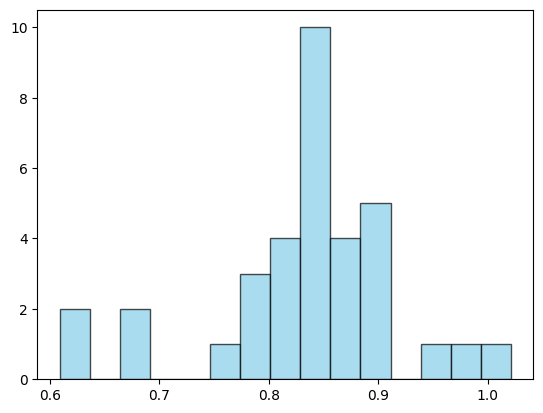

In [81]:
plt.hist(df['final_score'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)

### 9. Summary of missing_fields after all modification
Compute the missing_fields after all modification.

At the same time, check if the modification is correct and performed well.

In [83]:
# Verify consistency
def check_consistency(extracted_data, framework):
    missing_fields = []
    missing_question_id_count = 0
    empty_response_count = 0
    invalid_value_count = 0
    
    # Get all question_id and related information from extracted data
    extracted_dict = {item["question_id"]: item["response"] for item in extracted_data}
    
    # Check if the required question_id in each frame is in the extracted data
    for key, attributes in framework.items():
        if attributes["required"]:
            if key not in extracted_dict:
                # Increase count if question_id is missing
                missing_fields.append(key)
                missing_question_id_count += 1
            else:
                # Check if the response is empty
                response = extracted_dict[key]
                if not response:  # If response is empty
                    missing_fields.append(key)
                    empty_response_count += 1
                else:
                    # Check if the value of the field is invalid (value is 'N/A')
                    value = response.get("value", "").strip().lower()
                    if value == "n/a":
                        missing_fields.append(key)
                        invalid_value_count += 1
    
    return missing_fields, missing_question_id_count, empty_response_count, invalid_value_count

# Specify the input JSON file path containing all 34 reports
input_file_path = "../../data/esg_validation/modified_results_5.json"  

# Read extracted data from the JSON file
with open(input_file_path, "r") as file:
    extracted_data = json.load(file)

# Prepare CSV file for output
csv_file_path = '../../data/esg_validation/report_quality_missing_fields.csv'

# Write the results header to CSV
with open(csv_file_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Report", "Section", "Total Missing Fields", "Missing Question ID Count", "Empty Response Count", "Invalid Value Count", "Missing Fields"])

# Consistency check for the report
for report_key, data in extracted_data.items():
    missing_fields, missing_question_id_count, empty_response_count, invalid_value_count = check_consistency(data, esg_framework)
    missing_count = len(missing_fields)  # Count of total missing fields

    # Output results to CSV
    with open(csv_file_path, mode="a", newline="") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow([report_key, "Overall", missing_count, missing_question_id_count, empty_response_count, invalid_value_count, "; ".join(missing_fields)])
    
    # Output results to console
    print(f"Report: {report_key}")
    print(f"Total missing fields count: {missing_count}")
    print(f"Missing question ID count: {missing_question_id_count}")
    print(f"Empty response count: {empty_response_count}")
    print(f"Invalid value count: {invalid_value_count}")
    print(f"Missing fields: {missing_fields}\n")

Report: Great Eastern Holdings Ltd_report
Total missing fields count: 8
Missing question ID count: 2
Empty response count: 0
Invalid value count: 6
Missing fields: ['B-SOC_AGD_CEA_U30', 'B-SOC_AGD_CEA_B35', 'B-SOC_AGD_CEA_A50', 'B-GOV_ETB_ACD', 'B-GOV_ETB_ACT_N', 'B-GOV_ASS_ASR', 'B-SOC-EMP-TNM', 'B-SOC-EMP-TTN']

Report: Oversea-Chinese Banking Corporation Limited_report
Total missing fields count: 8
Missing question ID count: 2
Empty response count: 0
Invalid value count: 6
Missing fields: ['B-ENV_GHG_EIT', 'B-ENV_GHG_EI1', 'B-ENV_GHG_EI3', 'B-GOV_BOC_BIN', 'B-GOV_MAD_WMT', 'B-GOV_ETB_ACT_N', 'B-SOC-EMP-TNM', 'B-SOC-EMP-TTN']

Report: UOB-Kay Hian Holdings Limited_report
Total missing fields count: 37
Missing question ID count: 2
Empty response count: 0
Invalid value count: 35
Missing fields: ['B-ENV_GHG_AET', 'B-ENV_GHG_AE1', 'B-ENV_GHG_AE2', 'B-ENV_GHG_AE3', 'B-ENV_GHG_EIT', 'B-ENV_GHG_EI1', 'B-ENV_GHG_EI2', 'B-ENV_GHG_EI3', 'B-ENV_ENC_ECI', 'B-ENV_WAC_WCI', 'B-ENV_WAG_TWG', 'B-SOC

In [89]:
df_quality = pd.read_csv("../../src/validation/report_quality_missing_fields.csv")
df_quality.head()
df_quality["Quality Score"] = (45 - df_quality['Total Missing Fields'])/45

CSV file saved to: ../../data/esg_validation/low_quality.csv


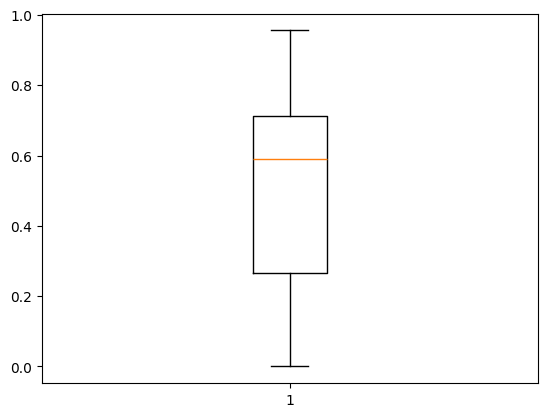

In [ ]:
# plt.boxplot(df_quality["Quality Score"])
df_low_quality = df_quality[df_quality["Quality Score"] < 0.2]
df_low_quality_selected = df_low_quality[["Report", "Quality Score"]]
output_path = '../../data/esg_validation/low_quality.csv'
df_low_quality_selected.to_csv(output_path, index=False)
print(f"CSV file saved to: {output_path}")

In [91]:
df_low_quality

,Report,Section,Total Missing Fields,Missing Question ID Count,Empty Response Count,Invalid Value Count,Missing Fields,Quality Score
10,Pine Capital Group Limited_report,Overall,39,2,0,37,B-ENV_GHG_AE1; B-ENV_GHG_AE2; B-ENV_GHG_AE3; B...,0.133333
11,Transcorp Holdings Limited_report,Overall,38,2,0,36,B-ENV_GHG_AET; B-ENV_GHG_AE1; B-ENV_GHG_AE2; B...,0.155556
18,British and Malayan Holdings Limited_report,Overall,39,2,0,37,B-ENV_GHG_AET; B-ENV_GHG_AE1; B-ENV_GHG_AE2; B...,0.133333
24,Sunrise Shares Holdings Ltd_report,Overall,45,2,0,43,B-ENV_GHG_AET; B-ENV_GHG_AE1; B-ENV_GHG_AE2; B...,0.000000
28,Jasper Investments Limited_report,Overall,43,2,0,41,B-ENV_GHG_AET; B-ENV_GHG_AE1; B-ENV_GHG_AE2; B...,0.044444
33,Innopac Holdings Limited_report,Overall,41,2,0,39,B-ENV_GHG_AET; B-ENV_GHG_AE1; B-ENV_GHG_AE2; B...,0.088889
